In [1]:
import pandas as pd

# Đọc file Excel
data = pd.read_excel('/content/Phone_dataset.xlsx')

# Ghi lại thành file CSV
data.to_csv('/content/Phone_dataset.csv', index=False)

In [2]:
!pip install underthesea


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import re
import underthesea
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [4]:
#Đưa về kiểu chữ thường
def text_lowercase(text):
    return text.lower()

In [5]:
#Loại bỏ các con số
def remove_number(text):
    result = re.sub(r'\d+', '', text)
    return result

In [6]:
#Loại bỏ các dấu câu
def remove_punctuation(text):
    text = text.replace(",", " ").replace(".", " ") \
    .replace(";", " ").replace("“", " ") \
    .replace(":", " ").replace("”", " ") \
    .replace('"', " ").replace("'", " ") \
    .replace("!", " ").replace("?", " ") \
    .replace("-", " ").replace("?", " ")
    return text

In [7]:
#Loại bỏ khoảng trắng thừa
def remove_whitespace(text):
    return  " ".join(text.split())

In [8]:
# Bỏ bớt các chữ cái giống nhau liên tiếp( Vd: quaaa -> qua)
def remove_similarletter(text):
    text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)
    return text

In [9]:
#Tách từ tiếng Việt sử dụng thư viện underthesea có sẵn
def VN_Tokenize(text,format='text'):
    return underthesea.word_tokenize(text)

In [19]:
print(VN_Tokenize("Tinh hoa công nghệ, đỉnh cao của điện thoại thông minh, tích hợp những công nghệ tối tân nhất vào trong một chiếc máy.Thiết kế sexy, cầm nắm đã tay, cảm giác mềm mại như làn da thiếu nữ vậy.. Màn hình đẹp, pin trâu, hiệu năng ổn định, chơi game tốt, đa nhiệm tuyệt vời, ứng dụng phong phú, khả năng tùy biến cao.Chụp ảnh đẹp, chụp xa, chụp gần gì cũng đều chụp rất tốt.Tuy nhiên vẫn hơi nặng tay, màn hình cong hơn chút thì đẹp hơn.Tổng kết lại thì mình vẫn vô cùng hài lòng với Samsung Galaxy S23 Ultra."))


['Tinh hoa', 'công nghệ', ',', 'đỉnh cao', 'của', 'điện thoại', 'thông minh', ',', 'tích hợp', 'những', 'công nghệ', 'tối tân', 'nhất', 'vào', 'trong', 'một', 'chiếc', 'máy', '.', 'Thiết kế', 'sexy', ',', 'cầm', 'nắm', 'đã', 'tay', ',', 'cảm giác', 'mềm mại', 'như', 'làn', 'da', 'thiếu nữ', 'vậy', '..', 'Màn hình', 'đẹp', ',', 'pin', 'trâu', ',', 'hiệu năng', 'ổn định', ',', 'chơi', 'game', 'tốt', ',', 'đa nhiệm', 'tuyệt vời', ',', 'ứng dụng', 'phong phú', ',', 'khả năng', 'tùy biến', 'cao', '.', 'Chụp', 'ảnh', 'đẹp', ',', 'chụp', 'xa', ',', 'chụp', 'gần', 'gì', 'cũng', 'đều', 'chụp', 'rất', 'tốt', '.', 'Tuy nhiên', 'vẫn', 'hơi', 'nặng', 'tay', ',', 'màn hình', 'cong', 'hơn', 'chút', 'thì', 'đẹp', 'hơn', '.', 'Tổng kết', 'lại', 'thì', 'mình', 'vẫn', 'vô cùng', 'hài lòng', 'với', 'Samsung Galaxy', 'S23 Ultra', '.']


In [10]:
#Loại bỏ các stopwords tiếng Việt sử dụng bộ stopwords có sẵn
def remove_VN_stopwords(text):
    file_stopwords = pd.read_csv('/content/vietnamese-stopwords.txt', encoding = 'UTF-8')
    file_stopwords.columns = ["Stop_words"]

    VN_stopword = []
    for i in file_stopwords["Stop_words"]:
        VN_stopword.append(i)

    text_token = VN_Tokenize(text)
    result = [word for word in text_token if word not in VN_stopword]
    return " ".join(result)

In [11]:
#Chuẩn hóa dữ liệu
def Util(text):
    replace_list = {
       ':v':'hihi', '<3':'yêu', '♥️':'yêu','❤':'yêu','a':'anh','ac':'anh chị','ace':'anh chị em','ad':'quản lý',
       'ae':'anh em','ah':'à','ak':'à','amin':'quản lý','androir':'android','app':'ứng dụng','auto ':'tự động',
       'ây':'vậy','b nào':'bạn nào','bằg':'bằng','băng':'bằng','băp':'bắp','băt':'bắt','battery':'pin','bể':'vỡ',
       'been':'bên','best':'nhất','best':'tốt nhất','bgqafy ':'ngày','bh':'bao giờ','bh':'bây giờ','bhx':'bảo hành',
       'bi':'bị','big':'lớn','bik':'biết','bin':'pin','bit':'biết','bít':'biết','bn':'bạn','bông tróc':'bong tróc', 'k': 'không', 'ok': 'được',
       'bro':'anh em','bt':'bình thường','bt':'biết','bth':'bình thường','bthg':'bình thường','bua':'bữa','bùn':'buồn',
       'buonc':'buồn','bx':'hộp','bye':'tạm biệt','c':'chị','cac':'các','cam':'máy ảnh','card':'thẻ','châu':'khỏe',
       'chiệu':'triệu','chíp':'chip','chội':'trội','chs':'chơi','chửa':'chữa','chug ':'chung','chup':'chụp','chuq':'chung',
       'clip':'đoạn phim','cmt':'bình luận','co':'có','cở':'cỡ','cọc':'cột','cpu':'chíp xử lý','cty':'công ty',
       'cua':'của','cũg':'cũng','cug ':'cũng','cuh':'cũng','cùi':'tệ','củng':'cũng','cụt':'cục','cv':'công việc',
       'cx':'cũng','đ':' đồng','dag':'đang','dăng':'văng','dấp':'lỗi','dất':'rất','đay':'đấy','đâỳ':'đầy','đc':'được',
       'dè':'rè','dể':'dễ','delay':'trễ','dêm':'đêm','đén':'đến','deplay ':'chậm','deu':'đều','diem':'điểm','dien':'diện',
       'đien':'điển','điễn':'điển','dienmayxanh':'điện máy xanh','dín':'dính','dis':'văng','diss':'văng','dk':'được',
       'dmx':'điện máy xanh','dô':'vào','dõ':'rõ','dỡ':'dở','đỗi':'đổi','download':'tải','drop':'tụt','dt':'điện thoại',
       'đt':'điện thoại','đth':'điện thoại','đthoai':'điện thoại','du':'dù','dùg':'dùng','dừg':'dừng','đứg':'đứng',
       'dụg ':'dụng','dung':'dùng','đụng':'chạm','đươc':'được','đuọc ':'được','đưowjc':'được','dựt ':'giật','dx':'được'
       ,'đx':'được','đy':'đi','e':'em','ế':'không bán được','êm':'tốt','f':'facebook','fabook':'facebook',
       'face':'facebook','fast':'nhanh','fb':'facebook','fim':'phim','fix':'sửa','flash sale':'giảm giá','fm':'đài',
       'for what':'vì sao','fps':'tốc độ khung hình','full':'đầy','future':'tương lai','game':'trò chơi','gem':'trò chơi',
       'geme':'trò chơi','gia tiên':'giá tiền','giât':'giật','giốg ':'giống','giử':'dữ','giùm':'dùm','gmae':'trò chơi',
       'gởi':'gửi','gold':'vàng','gơn':'hơn','good':'tốt','good jup':'tốt','gop':'góp','gửa':'gửi','gủng':'cái','h':'giờ',
       'haiz':'thở dài','hẵn ':'hẳn','hành':'hành','hazzz':'haizz','hc':'học','hcm':'hồ chí minh','hd':'chất lượng cao',
       'hdh':'hệ điều hành','hđh':'hệ điều hành','headphone':'tai nghe','hên':'may mắn','hẻo':'yếu','hẹo':'yếu','het':'hết',
       'hét':'hết','hic':'khóc','hieu':'hiểu','high-tech':'công nghệ cao','hít':'sử dụng','hiu':'hiểu','hỉu':'hiểu',
       'hk':'không','hn':'hà nội','hnay':'hôm nay','hoài':'nhiều lần','hoi':'hơi','hới':'hơi','hời':'tốt',
       'hoi han':'hối hận','hok':'không','hong':'không','hông':'không','hot':'nổi bật','hqua':'hôm qua','hs':'học sinh',
       'hssv':'học sinh sinh viên','hut':'hút','huway ':'huawei','huwei ':'huawei','í':'ý','I like it':'tôi thích nó',
       'ik':'đi','ip':'iphone','j':'gì','k':'không','kàm':'làm','kb':'không biết','kg':'không','kh ':'khách hàng',
       'khach':'khách hàng','khát phục':'khắc phục','khj':'khi','khoá ':'khóa','khóai ':'thích','khoẻ':'khỏe',
       'khoẽ':'khỏe','khôg':'không','khoi đong':'khởi động','khong':'không','khoong ':'không','khuân':'khuôn',
       'khủg':'khủng','kím':'kiếm','kipo':'tiêu cực','ko':'không','kt':'kiểm tra','ktra':'kiểm tra','la':'là',
       'lác':'lỗi','lắc':'lỗi','lag':'lỗi','laii':'lại','lak':'giật','lan':'lần','lãng':'giật','lap':'máy tính',
       'laptop':'máy tính','lay':'này','len toi':'lên tới','les':'led','lg':'lượng','lí':'lý','lien':'liên',
       'like':'thích','liti':'nhỏ','live stream':'phát sóng trực tiếp','lm':'làm','ln':'luôn','loadd':'tải ',
       'lôi':'lỗi','lổi':'lỗi','LOL ':'trò chơi','lởm':'kém chất lượng','lỏng lẽo':'lỏng lẻo','luc':'lúc','lun':'luôn',
       'luong':'lượng','luot':'lướt','lưot ':'lượt','m':'mình','mạ':'trời','mắc công':'mất công','macseger':'messenger',
       'mag':'màn','main':'chính','mak':'mà','man':'màn','màng':'màn','màng hình':'màn hình','mao ':'mau','mẩu':'mẫu',
       'mầu ':'màu','max':'lớn nhất','may':'máy','mèn':'màn','méo gì':'làm gì','mih':'mình','mìk':'mình','min':'nhỏ nhât',
       'mìn':'mình','mjh':'mình','mjk':'mình','mjnh':'minh','mk':'mình','mn':'mọi người','mng ':'mọi người','mo':'đâu',
       'mò':'tìm','mobile':'điện thoại','mog':'mong','moi':'mới','mơi':'mới','ms':'mới','mún':'muốn','mước':'mức',
       'mược':'mượt','muot':'mượt','mỷ':'mỹ','n':'nó','n':'nói chuyện','nãn':'nản','nayd':'này','nc':'nói chuyện',
       'nch':'nói chuyện','nch':'nói chung','nếo ':'nếu','ng':'người','ngan':'ngang','nge':'nghe','nghiêm':'nghiệm',
       'ngĩ':'nghĩ','ngốn':'sử dụng','nguon':'nguồn','nhah':'nhanh','nhan vien':'nhân viên','nhay':'nhạy','nhe':'nhé',
       'nhèo':'nhòe','nhiet':'nhiệt','nhiểu':'nhiều','nhiu':'nhiều','nhìu':'nhiều','nhoè':'nhòe','như v':'như vậy',
       'nhug':'nhưng','nhưg':'nhưng','nhữg':'những','nhung':'nhưng','nhuoc':'nhược','nhượt':'nhược','nock ao':'hạ gục',
       'noi':'nói','nống':'nóng','not':'lưu ý','ns ':'nói','nsx':'ngày sản xuất','nt':'nhắn tin','ntin':'nhắn tin',
       'ntn':'như thế nào','nũa':'nữa','nut ':'nút','nv':'nhân viên','nz':'như vậy','ô xi':'oxy','ofice':'văn phòng',
       'ok':'được','ôk':'được','oke':'được','okee':'được','oki':'được','okie':'được','onl':'sử dụng',
       'ộp ẹp':'không chắc chắn','option':'tùy chọn','or':'hoặc','out':'thoát','oỳ':'rồi','pải':'phải','phảm':'phẩm',
       'phẩn':'phẩm','phan van':'phân vân','phèo':'vậy','phut ':'phút','pít':'biết','pro':'chất lượng cao','pùn':'buồn',
       'pv':'giới thiệu','qá':'quá','qc':'quảng cáo','qtv':'quản trị viên','qua ve':'qua vẻ','quang trọng':'quan trọng',
       'qus':'quá','r ':'rồi','rat':'rất','rát':'rất','rắt':'rất','rata':'rất','rễ':'dễ','rep':'trả lời',
       'research':'nghiên cứu','reset':'cài đặt lại','restart':'khởi động lại','review':'đánh giá','rì':'gì',
       'rinh':'mua','rỏ':'rõ','rùi':'rồi','rùng':'dùng','s':'sao','sac':'sạc','sài':'xài','sài':'dùng','sale':'giảm giá',
       'sale off':'giảm giá','sâng':'sáng','sạt':'sạc','saving':'tiết kiệm','sd':'sử dụng','sdt':'số điện thoại',
       'seal':'mới','search':'tìm kiếm','sefil':'chụp ảnh','selfie':'chụp ảnh','setting':'cài đặt','setup':'cài đặt',
       'sexy':'quyến rũ','shiper':'nhân viên giao hàng','shop':'cửa hàng','skill':'kỹ năng','smooth':'mượt',
       'so good':'rất tốt','sp':'sản phẩm','sphẩm':'sản phẩm','stars':'sao','sử':'xử','suất':'xuất','sưj':'sự',
       'sước':'xước','super':'siêu','support':'hỗ trợ','sụt':'tụt','sv':'sinh viên','sx':'sản xuất','t':'tôi',
       'T G D Đ':'thế giới di động','tằm ':'tầm','tes':'kiểm tra','test':'kiểm tra','tet':'tết','teung':'trung',
       'tg':'thời gian','tgdd':'thế giới di động','tgdđ':'thế giới di động','thag':'tháng','thág':'tháng','ship':'giao','Ship':'giao',
    }
    text = text.split()
    len_ = len(text)
    for i in range(0, len_):
        for k, v in replace_list.items():
            if (text[i]==k):
                text[i] = v
    return " ".join(text)

In [12]:
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"
                u"\U0001F300-\U0001F5FF"
                u"\U0001F680-\U0001F6FF"
                u"\U0001F1E0-\U0001F1FF"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE) # Unicode emojis.

In [20]:
def text_preprocessing_util(data):
    result_preprocess = []
    for i in data:
        i = str(i)
        text = text_lowercase(i)
        text = re.sub(emoji_pattern, " ", text)
        text = remove_similarletter(text)
        text = remove_number(text)
        text = remove_punctuation(text)
        text = remove_whitespace(text)
        text = remove_VN_stopwords(text)
        text = Util(text)
        result_preprocess.append(text)
    return result_preprocess

In [21]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset
from torchvision.transforms import v2
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import tensorflow as tf

In [22]:
BATCH_SIZE = 128
MAX_SEQ_LEN = 128
MAX_FEATURES = 5000 # vocab size
EMBEDDING_DIMS = 64
RANDOM_SEED = 123
LR=1e-4
EPOCHS=30
checkpoint_root = '/kaggle/working/'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [23]:
data = pd.read_csv("/content/Phone_dataset.csv")
data.dropna(inplace=True)
data

,Comment,Label
0,Mua điện thoại tại hệ thống về lên website giá...,Neutral
1,"Mới mua 23ul, ngày 1.5. cập nhật ui6.1 sọc màn...",Neutral
2,"Mình có mua số 23 ultra ngày 30/04, xài đc 1 t...",Negative
3,"Chào điện máy Xanh, tôi có mua con S23 Ultra b...",Positive
4,"Máy tốt, không lỗi gì nhé. Camera và bộ công c...",Positive
...,...,...
5013,Ok !,Positive
5014,"Pin nhanh hết, nói chung ko có ai để nói.",Positive
5015,Rất tốt.,Positive
5016,Sp ok?,Positive


In [24]:
X_data = data["Comment"]
Y_data_one = data["Label"]
Y_data = []
for label in Y_data_one:
    if label == "Negative":
        Y_data.append(-1)
    elif label == "Neutral":
        Y_data.append(0)
    elif label == "Positive":
        Y_data.append(1)
    else:
        print(label)
X_data = text_preprocessing_util(X_data)

In [25]:
X_data

['mua điện thoại hệ thống website giá',
 'mua ul cập nhật ui sọc màn đẻ đổi không cửa hàng',
 'mua ultra / xài được tuần tróc viền camera mặc dù ốp lưng hàng cao cấp tróc thất vọng',
 'chào điện máy xanh mua sao ultra siêu thị mua',
 'máy lỗi nhé camera công cụ chỉnh sửa ảnh tiện dụng',
 'mua tr mấy hôm nay tr chán',
 'máy mắn được',
 'hài lòng sản phẩm nhân viên siêu thị thế giới di động thị trấn thủ thừa tỉnh long an nhiệt tình',
 'loa hơi camera chụp hình đẹp note hơi thất vọng',
 'camera đẹp',
 'hài lòng sản phẩm sam sung sa ultra',
 'tầm giá trải nghiệm',
 'xài được g bù z quản lý',
 'minh mua mấy rớt hình lỗi thi bao tai minh cân mấy hang bao hanh bao hình thi tr giám sai',
 'dòng sản phẩm',
 '',
 '',
 'gOd',
 'máy tốt đẹp pin trâu mượt',
 'hài lòng sản phẩm ultra',
 'pin sóng dở',
 'ủng hộ điện máy xanh',
 'tinh hoa công nghệ đỉnh cao điện thoại thông minh tích hợp công nghệ tối tân máy thiết kế quyến rũ cầm nắm cảm giác mềm mại làn da thiếu nữ màn hình đẹp pin trâu hiệu năng ổn

In [26]:
def one_hot_labels(Y):
    label = np.zeros(3,)
    label[Y+1] = 1
    return label

In [27]:
Y_data = [one_hot_labels(y) for y in Y_data]


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=RANDOM_SEED)

In [29]:
# Khai báo layer text vectorization
text_vectorization_layer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_FEATURES, # Kích thước bộ từ vựng
    output_mode='int', # Giá trị token là chỉ mục của từ trong vocab
    output_sequence_length=MAX_SEQ_LEN # Số token tối đa trong 1 vector
)

text_vectorization_layer.adapt(X_data)

In [30]:
rnn = tf.keras.Sequential([
  tf.keras.Input(shape=(MAX_SEQ_LEN,), name='input_layer'),
  # Embedding Layer (chuyển đổi các token thành các vector)
  tf.keras.layers.Embedding(input_dim=MAX_FEATURES+1,
                            output_dim=EMBEDDING_DIMS,
                            embeddings_initializer=tf.random_uniform_initializer(seed=RANDOM_SEED),

                            mask_zero=True,
                            name='embedding_layer'),
  # RNN Layer 1
  tf.keras.layers.SimpleRNN(32,
                        return_sequences=True,
                        kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                        name='rnn_layer_1'),
  # RNN Layer 2
  tf.keras.layers.SimpleRNN(32,
                        return_sequences=False,
                        kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                        name='rnn_layer_2'),

  # Fully-connected Layer 1
  tf.keras.layers.Dense(16,
                        activation='relu',
                        kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                        name='fl_layer_1'),

  # Output Layer
  tf.keras.layers.Dense(3,
                        activation='softmax',
                        kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                        name='output_layer')
  ],
  name='rnn_model')

rnn.summary()

Model: "rnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)          │ (None, 128, 64)             │         320,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_layer_1 (SimpleRNN)              │ (None, 128, 32)             │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_layer_2 (SimpleRNN)              │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fl_layer_1 (Dense)                   │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 325,827 (1.24 MB)

 Trainable params: 325,827 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
rnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR), # Sử dụng optimizer Adam
    loss=tf.keras.losses.CategoricalCrossentropy(), # Sử dụng hàm loss CategorialCrossEntropy
    metrics=['accuracy'] # Sử dụng thêm độ đo đánh giá Accuracy
)

In [32]:
def tf_train(model, X_train, y_train, X_test, y_test, epochs, batch_size, checkpoint_filepath):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
    X_train = text_vectorization_layer(X_train)
    X_test = text_vectorization_layer(X_test)
    y_train = tf.convert_to_tensor(y_train)
    y_test = tf.convert_to_tensor(y_test)
    history = model.fit(
        X_train, # Huấn luyện với bộ train_ds
        y_train,
        batch_size=batch_size,
        validation_data=(X_test, y_test), # Đánh giá trên bộ val_ds
        epochs=epochs, # Huấn luyện với số lần lặp = số epochs
        callbacks=[model_checkpoint_callback]
    )

    #plot accuracy
    fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper right')
    plt.show()

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.3252 - loss: 1.1372 - val_accuracy: 0.4382 - val_loss: 1.1017
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.5049 - loss: 1.0814 - val_accuracy: 0.5876 - val_loss: 1.0681
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6504 - loss: 1.0497 - val_accuracy: 0.6653 - val_loss: 1.0421
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7039 - loss: 1.0203 - val_accuracy: 0.6892 - val_loss: 1.0164
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7313 - loss: 0.9782 - val_accuracy: 0.7012 - val_loss: 0.9835
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7591 - loss: 0.9249 - val_accuracy: 0.7062 - val_loss: 0.9446
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7688 - loss: 0.8703 - val_accuracy: 0.7181 - val_loss: 0.9002
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7811 - loss: 0.8128 - val_accuracy: 0.7231 -

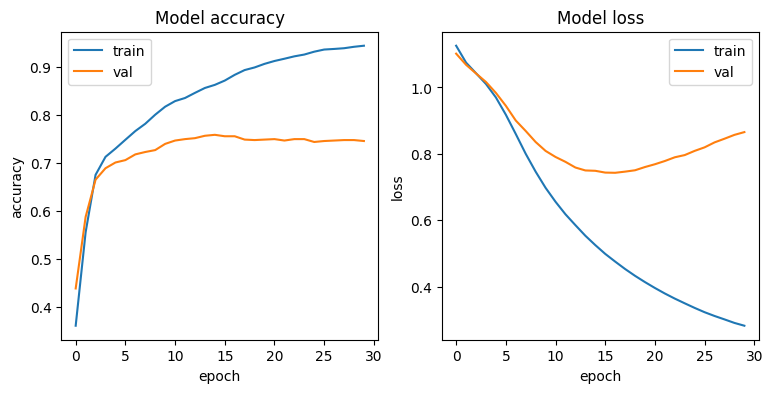

In [33]:
tf_train(rnn, X_train, y_train, X_test, y_test, EPOCHS, BATCH_SIZE, checkpoint_root+'rnn.model.keras')

In [35]:
rnn.save('rnn_sentiment_model.h5')

In [43]:
from keras.models import load_model

model_sentiment = load_model("/content/rnn_sentiment_model.h5")

In [39]:
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score



In [59]:
X_test = text_vectorization_layer(X_test)



UnimplementedError: Exception encountered when calling TextVectorization.call().

[1m{{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cast int64 to string is not supported [Op:Cast] name: [0m

Arguments received by TextVectorization.call():
  • inputs=tf.Tensor(shape=(1004, 128), dtype=int64)

In [65]:
y_test = np.argmax(y_test, axis=1)

In [66]:
X_test

<tf.Tensor: shape=(1004, 128), dtype=int64, numpy=
array([[   8,   11,   18, ...,    0,    0,    0],
       [  14,   81,    3, ...,    0,    0,    0],
       [   5,    4,   22, ...,    0,    0,    0],
       ...,
       [1799,   71, 2403, ...,    0,    0,    0],
       [  20,    0,    0, ...,    0,    0,    0],
       [   7,    9,    0, ...,    0,    0,    0]])>

In [67]:
y_pred = model_sentiment.predict(X_test)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [68]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [63]:
print(f"y_test shape: {y_test.shape}, y_test dtype: {y_test.dtype}")
print(f"y_pred_classes shape: {y_pred_classes.shape}, y_pred_classes dtype: {y_pred_classes.dtype}")


y_test shape: (1004, 3), y_test dtype: <dtype: 'float64'>
y_pred_classes shape: (1004,), y_pred_classes dtype: int64


In [69]:
print(classification_report(y_test, y_pred_classes))


              precision    recall  f1-score   support

           0       0.56      0.56      0.56       168
           1       0.31      0.23      0.27       143
           2       0.85      0.90      0.87       693

    accuracy                           0.75      1004
   macro avg       0.57      0.56      0.57      1004
weighted avg       0.73      0.75      0.73      1004

